In [2]:
import time
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from qiskit_algorithms.utils import algorithm_globals

from qiskit.circuit.library import ZZFeatureMap
from qiskit.circuit.library import RealAmplitudes
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
from qiskit_machine_learning.algorithms.classifiers import VQC

# 1. Data Loading

In [3]:
data_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
dataset = (
    pd.read_excel(io=data_url, header=1)
    .drop(columns=["ID"])
    .rename(
        columns={"PAY_0": "PAY_1", "default payment next month": "default"}
    )
)

In [4]:
dataset.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [5]:
X_df = pd.get_dummies(dataset.drop(columns=["default", "SEX", "EDUCATION", "MARRIAGE"]))
X = X_df.to_numpy()
Y = dataset.loc[:, "default"].to_numpy()

In [6]:
mod = sm.Logit(Y, X)
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.474583
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                30000
Model:                          Logit   Df Residuals:                    29980
Method:                           MLE   Df Model:                           19
Date:                Mon, 29 Apr 2024   Pseudo R-squ.:                  0.1019
Time:                        22:40:54   Log-Likelihood:                -14237.
converged:                       True   LL-Null:                       -15853.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -1.064e-06   1.52e-07     -6.982      0.000   -1.36e-06   -7.66e-07
x2            -0.0243      0.

In [14]:
sig_vars = X_df.columns[res.pvalues <= 1e-4].to_list()
print(sig_vars)
print(len(sig_vars), "significant variables")

['LIMIT_BAL', 'AGE', 'PAY_1', 'BILL_AMT1', 'PAY_AMT1', 'PAY_AMT2']
6 significant variables


In [15]:
X_sig = X_df[sig_vars].to_numpy()

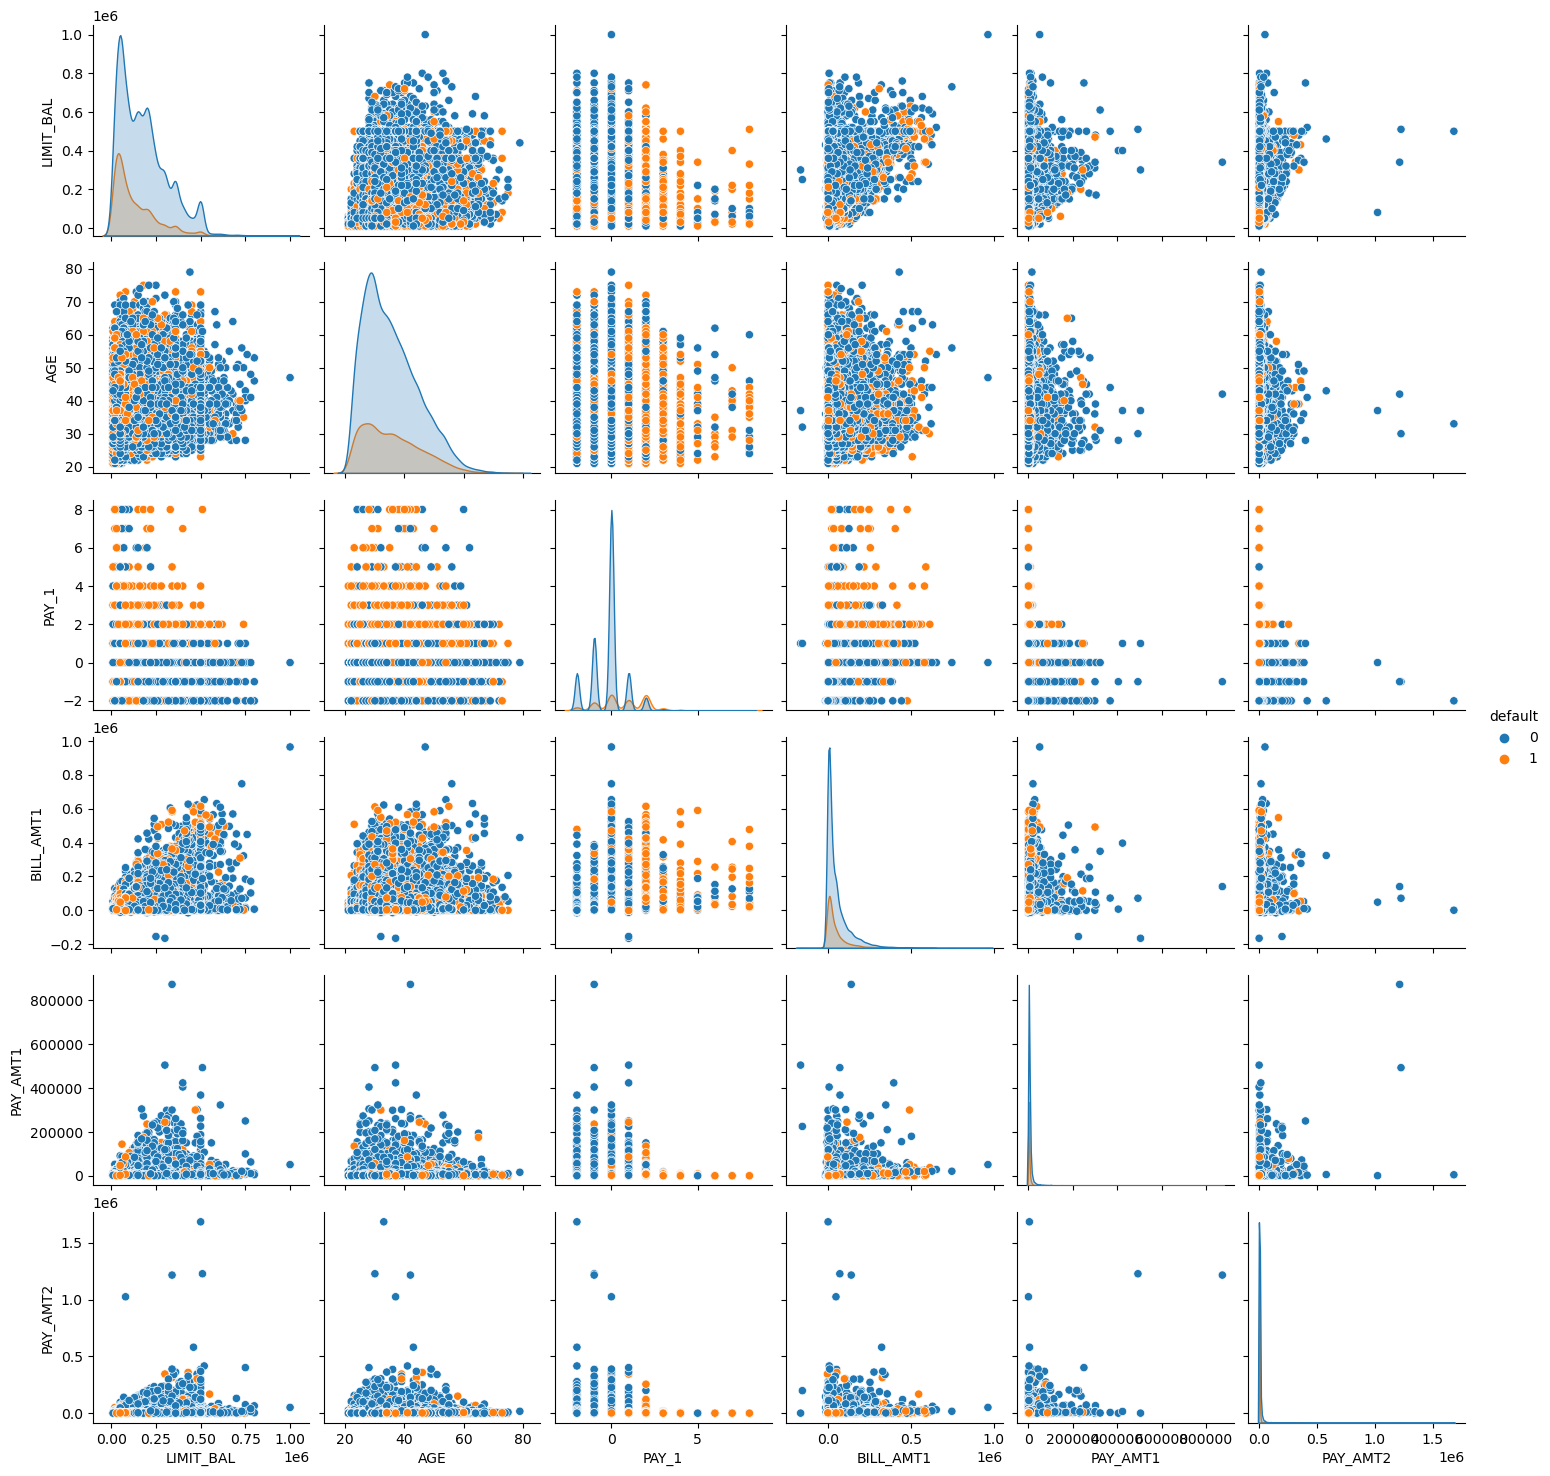

In [16]:
sns.pairplot(dataset, vars=sig_vars, hue="default")

# 2. Training Quantum Model

In [17]:
features = X_sig
labels = Y

algorithm_globals.random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

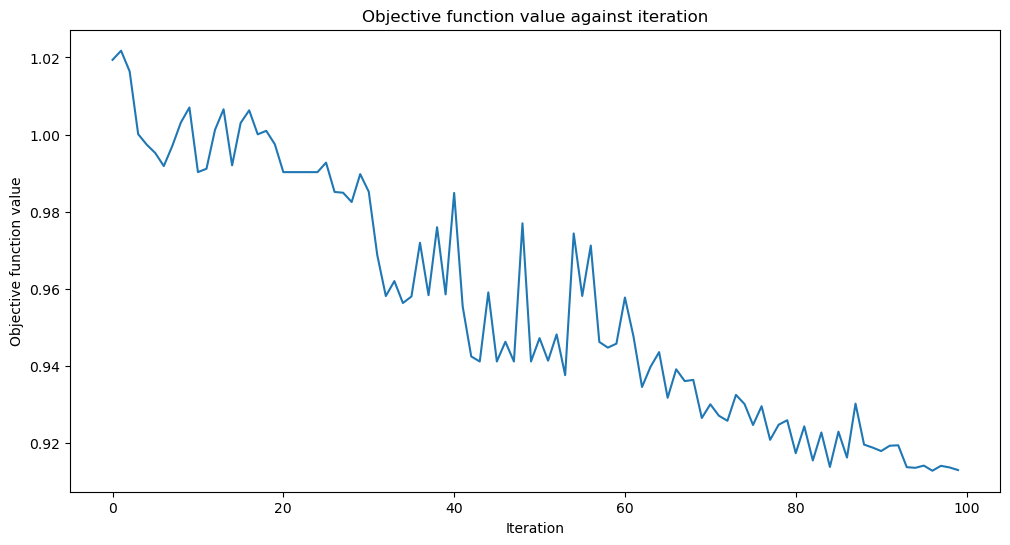

Training time: 21357 seconds


In [18]:
num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
# feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
# ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

optimizer = COBYLA(maxiter=100)
sampler = Sampler()

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [19]:
train_score_q4 = vqc.score(train_features, train_labels)
test_score_q4 = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the training dataset: 0.68
Quantum VQC on the test dataset:     0.67


In [20]:
vqc.save("results/models/vqc_taiwan_credit_6vars.pkl")

In [21]:
y_pred = vqc.predict(test_features)

In [34]:
test_df = pd.DataFrame(np.hstack([test_features, np.expand_dims(test_labels, axis=1), np.expand_dims(y_pred, axis=1)]))
test_df.columns = sig_vars + ["default", "default_pred"]

In [35]:
test_df.head()

,LIMIT_BAL,AGE,PAY_1,BILL_AMT1,PAY_AMT1,PAY_AMT2,default,default_pred
0,40000,26,-1,28991,1300,1000,0,1
1,80000,59,0,75662,3212,2106,0,0
2,170000,30,2,155910,6800,6500,1,1
3,200000,41,-2,23570,742,0,1,0
4,50000,43,0,8214,1140,1150,0,0


In [36]:
test_df.to_csv("results/predictions/vqc_taiwan_credit_6vars_pred.pkl")

# 3. Multi-Accuracy

In [40]:
# defining boolean functions F

test_df[sig_vars]

,LIMIT_BAL,AGE,PAY_1,BILL_AMT1,PAY_AMT1,PAY_AMT2
0,40000,26,-1,28991,1300,1000
1,80000,59,0,75662,3212,2106
2,170000,30,2,155910,6800,6500
3,200000,41,-2,23570,742,0
4,50000,43,0,8214,1140,1150
...,...,...,...,...,...,...
5995,160000,51,0,1380,1331,2473
5996,70000,53,0,14054,1554,1263
5997,10000,45,1,6321,0,4312
5998,50000,50,0,45771,2266,0


In [39]:
np.abs(test_df["default"] - test_df["default_pred"])

0       1
1       0
2       0
3       1
4       0
       ..
5995    1
5996    0
5997    0
5998    0
5999    0
Length: 6000, dtype: int64